# Overview of py4cytoscape
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cytoscape/cytoscape-automation/new/master/for-scripters/Python/Overview-of-py4cytoscape.ipynb)

**by Kozo Nishida, Alexander Pico, Tanja Muetze, Georgi Kolishovski, Paul Shannon, Barry Demchak**

**py4cytoscape 0.0.11**

Cytoscape is a well-known bioinformatics tool for displaying and exploring biological networks. Python is a powerful programming language and environment for statistical and exploratory data analysis. *py4cytoscape* uses CyREST to communicate between **Python** and Cytoscape, allowing any graphs (e.g., igraph or dataframes) to be viewed, explored and manipulated with the Cytoscape point-and-click visual interface. Thus, via py4cytoscape, these two quite different, quite useful bioinformatics software environments are connected, mutually enhancing each other, providing new possibilities for exploring biological data.
 
## Prerequisites
In addition to this package (py4cytoscape), you will need:

- Cytoscape 3.8 or greater, which can be downloaded from https://cytoscape.org/download.html. Simply follow the installation instructions on screen.
- Complete installation wizard
- Launch Cytoscape
- If your Cytoscape is 3.8.2 or earlier, install FileTransfer App (Follow [here](https://py4cytoscape.readthedocs.io/en/0.0.10/tutorials/index.html) to do it.)

**NOTE: To run this notebook, you must manually start Cytoscape first – don’t proceed until you have started Cytoscape.**

### Setup required only in a remote notebook environment
If you're using a remote Jupyter Notebook environment such as Google Colab, run the cell below.
(If you're running a local Jupyter Notebook server on the desktop machine same with Cytoscape, you don't need to do that.)

In [ ]:
_PY4CYTOSCAPE = 'git+https://github.com/cytoscape/py4cytoscape@0.0.11'
import requests
exec(requests.get("https://raw.githubusercontent.com/cytoscape/jupyter-bridge/master/client/p4c_init.py").text)
IPython.display.Javascript(_PY4CYTOSCAPE_BROWSER_CLIENT_JS) # Start browser client

Note that to use the current py4cytoscape release (instead of v0.0.11), remove the _PY4CYTOSCAPE= line in the snippet above.

## Getting started

First, confirm that you have everything installed and running:

In [1]:
import py4cytoscape as p4c
p4c.cytoscape_ping()
p4c.cytoscape_version_info()

You are connected to Cytoscape!


{'apiVersion': 'v1',
 'cytoscapeVersion': '3.8.2',
 'automationAPIVersion': '1.2.0',
 'py4cytoscapeVersion': '0.0.10'}

## My first network

Let’s create a Cytoscape network from some basic Python objects

In [2]:
import pandas as pd
nodes = pd.DataFrame(data={'id': ["node 0","node 1","node 2","node 3"], 'group': ["A","A","B","B"], 'score': [20,10,15,5]})
edges = pd.DataFrame(data={'source': ["node 0","node 0","node 0","node 2"], 'target': ["node 1","node 2","node 3","node 3"], 'interaction': ["inhibits","interacts","activates","interacts"], 'weight': [5.1,3.0,5.2,9.9]})

p4c.create_network_from_data_frames(nodes, edges, title="my first network", collection="DataFrame Example")

Applying default style...
Applying preferred layout


{'networkSUID': 51}

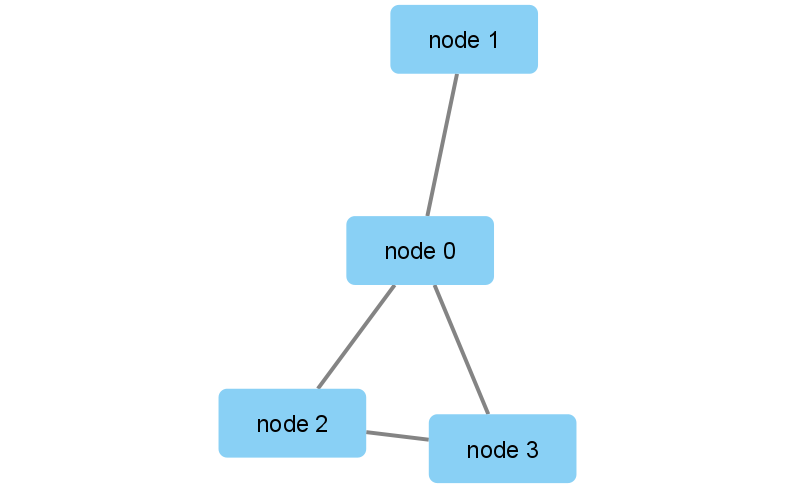

In [3]:
p4c.notebook_export_show_image()

### Switch styles

Check out the marquee style!

In [4]:
p4c.set_visual_style('Marquee')

{'message': 'Visual Style applied.'}

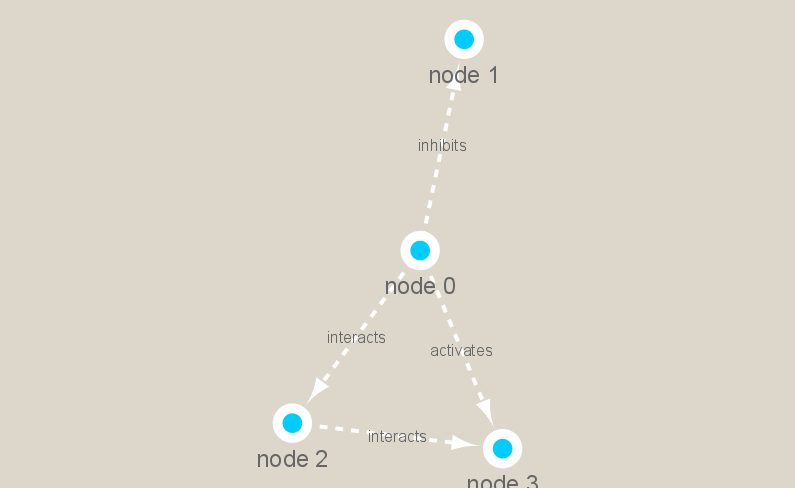

In [5]:
p4c.notebook_export_show_image()

### My own style

Create your own style with node attribute fill mappings and some defaults

In [6]:
style_name = "myStyle"
defaults = {'NODE_SHAPE': "diamond", 'NODE_SIZE': 30, 'EDGE_TRANSPARENCY': 120, 'NODE_LABEL_POSITION': "W,E,c,0.00,0.00"}
nodeLabels = p4c.map_visual_property('node label', 'id', 'p') #'p' means 'passthrough' mapping
edgeWidth = p4c.map_visual_property('edge width', 'weight', 'p') #'p' means 'passthrough' mapping
p4c.create_visual_style(style_name, defaults, [nodeLabels, edgeWidth])
p4c.set_visual_style(style_name)

{'message': 'Visual Style applied.'}

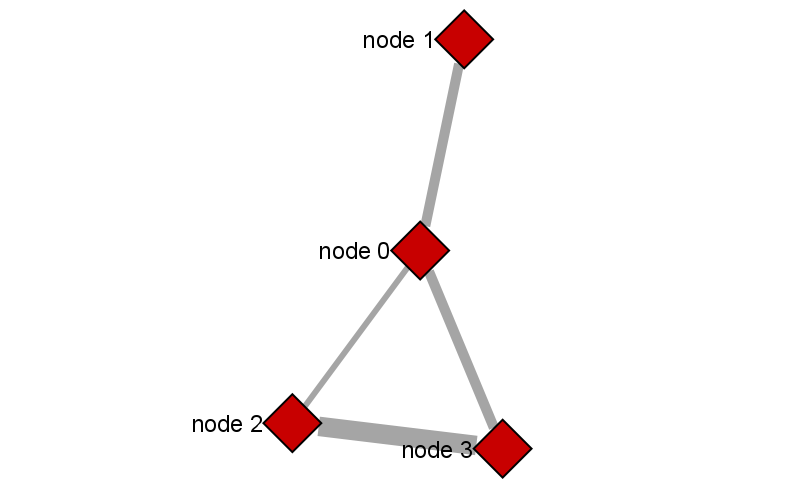

In [7]:
p4c.notebook_export_show_image()

py4cytoscape has the value generator functions.
This makes it easy to automatically associate colors or multiple values with node (or edge) attribute values.

In [8]:
from py4cytoscape import gen_node_color_map
from py4cytoscape import gen_edge_arrow_map
p4c.set_node_color_mapping(**gen_node_color_map('group', mapping_type='d', style_name=style_name)) #'d' means 'discrete' mapping
p4c.set_edge_target_arrow_shape_mapping(**gen_edge_arrow_map('interaction', style_name=style_name))

''

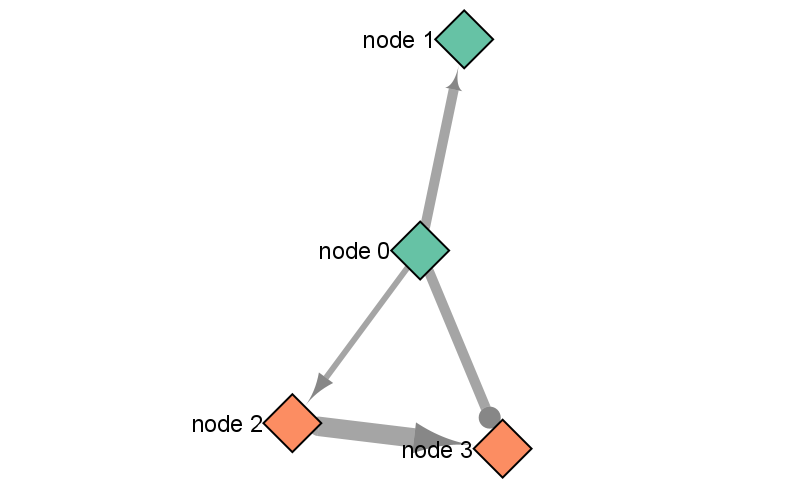

In [9]:
p4c.notebook_export_show_image()

*Pro-tip: if you want to set NODE_WIDTH and NODE_HEIGHT independently, you also need to unlock the node dimensions with…*

In [10]:
p4c.lock_node_dimensions(False, style_name)

{'views': [69]}

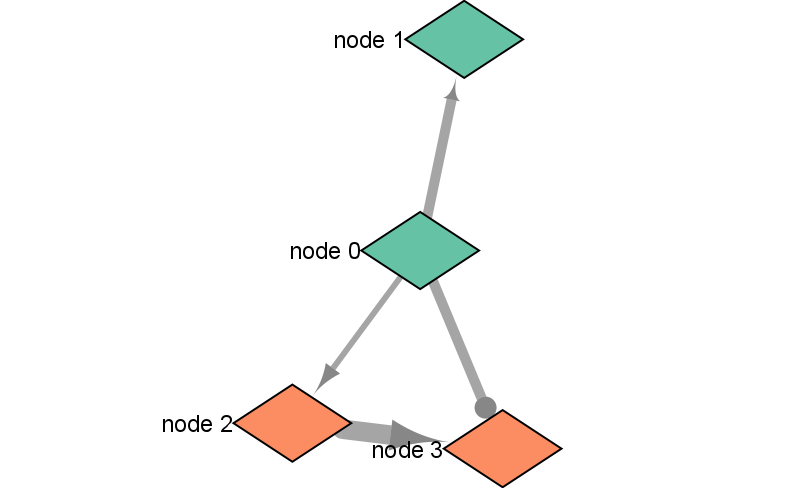

In [11]:
p4c.notebook_export_show_image()

## Biological graph example

Here we create a 4-node graph in Python, send it to Cytoscape for display and layout. For the sake of simplicity, no node attributes and no visual styles are included; those topics are covered in subsequent steps.

In [12]:
nodes = pd.DataFrame(data={'id': ["A", "B", "C", "D"]})
edges = pd.DataFrame(data={'source': ["C", "B", "B", "B"], 'target': ["D", "A", "D", "C"]})

p4c.create_network_from_data_frames(nodes, edges, title="simple network", collection="Biological Example")

Applying default style...
Applying preferred layout


{'networkSUID': 94}

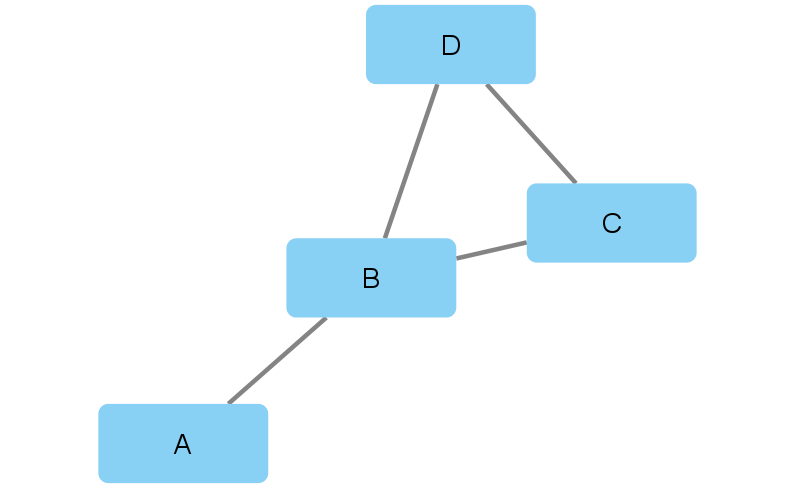

In [13]:
p4c.notebook_export_show_image()

You should now have the structure of this 4-node graph with a basic, default style. Fortunately, Cytoscape has some built-in rendering rules in which (and unless instructed otherwise) nodes and edges are rendered and a default (user-preference) layout algorithm is applied.

### Add node attributes

We often know quite a lot about the nodes and edges in our graphs. By conveying this information visually, the graph will be easier to explore. For instance, we may know that protein A phosphorylates protein B, that A is a kinase and B a transcription factor, and that their mRNA expression (compared to a control) is a log2 fold change of 1.8 and 3.2 respectively. One of the core features of Cytoscape is visual styles, which allow you to specify how data values (e.g., kinase,transcription factor; expression ratios) should be conveyed in the visual properties of the graph (e.g., node shape, node color or size).

We continue with the simple 4-node graph, adding two kinds data values (moleculeType and log2fc). The easiest way to do this is via pandas DataFrame s. However, you can also include attributes together with the original graph models as igraph s or pandas DataFrame s and then use the provided create functions to create and load in a single step (see *p4c.create_network_from_igraph() and p4c.create_network_from_data_frames()* functions). Check out the other Notebooks for more examples.


In [14]:
p4c.get_table_columns()

,SUID,shared name,name,selected,id
104,104,A,A,False,A
105,105,B,B,False,B
106,106,C,C,False,C
107,107,D,D,False,D


In [15]:
df = pd.DataFrame(data={'moleculeType': ['kinase','TF','cytokine','cytokine'], 'log2fc': [1.8,3.0,-1.2,-2.5]})
df.index = ['A','B','C','D']
df

,moleculeType,log2fc
A,kinase,1.8
B,TF,3.0
C,cytokine,-1.2
D,cytokine,-2.5


In [16]:
p4c.load_table_data(df)

'Success: Data loaded in defaultnode table'

In [17]:
p4c.get_table_columns()

,SUID,shared name,name,selected,id,moleculeType,log2fc,row.names
104,104,A,A,False,A,kinase,1.8,A
105,105,B,B,False,B,TF,3.0,B
106,106,C,C,False,C,cytokine,-1.2,C
107,107,D,D,False,D,cytokine,-2.5,D


Note that adding the attributes does not in itself cause the appearance of the graph to change. Such a change requires that you specify and apply visual style mappings, which will be explained in the *next* section. You can, however, examine these attributes in Cytoscape, using Cytoscape’s the **Data Panel** to display data values associated with selected nodes immediately below the Cytoscape window.

### Modifying the display: defaults and mappings

py4cytoscape provides an easy way to not only change the default styles, but more interestingly, py4cytoscape also provides easy access to *mapping* your data to visual styles, e.g., allowing the size, shape and color of nodes and edges to be determined by the data you have associated with those nodes and edges.

First, let’s change the the defaults.

In [18]:
p4c.set_node_shape_default('OCTAGON')

style_name not specified, so updating "default" style.


''

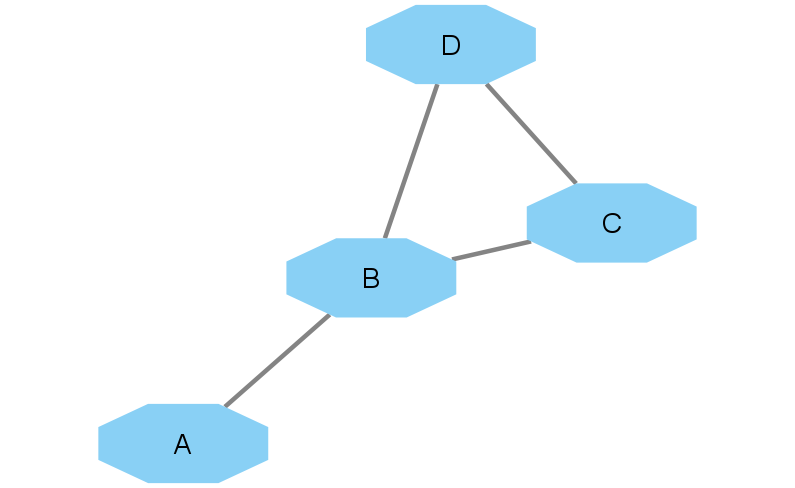

In [19]:
p4c.notebook_export_show_image()

In [20]:
p4c.set_node_color_default('#AAFF88')

style_name not specified, so updating "default" style.


''

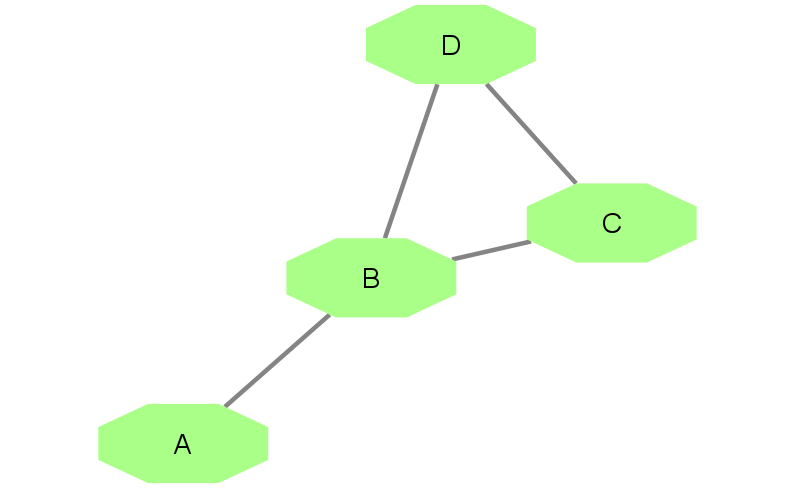

In [21]:
p4c.notebook_export_show_image()

In [22]:
p4c.set_node_size_default(60)

style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.


''

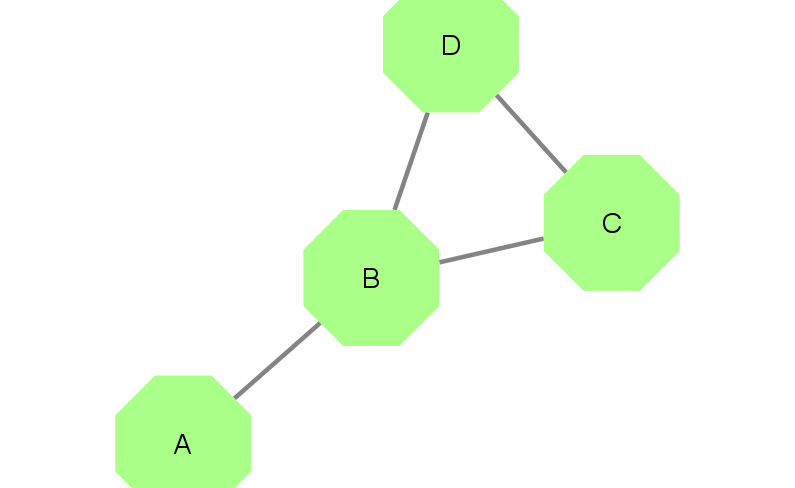

In [23]:
p4c.notebook_export_show_image()

In [24]:
p4c.set_node_font_size_default(30)

style_name not specified, so updating "default" style.


''

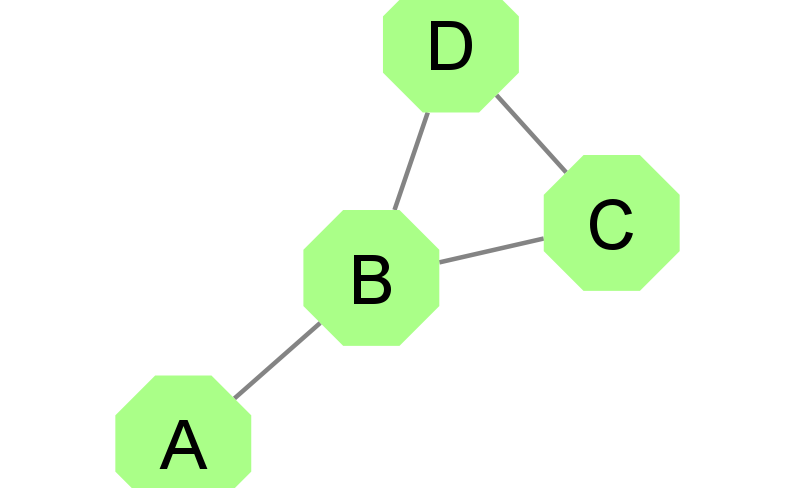

In [25]:
p4c.notebook_export_show_image()

Now we will add some visual mappings. Let’s map `moleculeType’ to node shapes. First, we can see which shapes are available in Cytoscape, then we can define the mapping with paired lists.

In [26]:
p4c.get_node_shapes()

['PARALLELOGRAM',
 'ROUND_RECTANGLE',
 'RECTANGLE',
 'TRIANGLE',
 'ELLIPSE',
 'OCTAGON',
 'HEXAGON',
 'VEE',
 'DIAMOND']

In [27]:
column = 'moleculeType'
values = ['kinase', 'TF', 'cytokine']
shapes = ['DIAMOND', 'TRIANGLE', 'RECTANGLE']

p4c.set_node_shape_mapping(column, values, shapes)

style_name not specified, so updating "default" style.


''

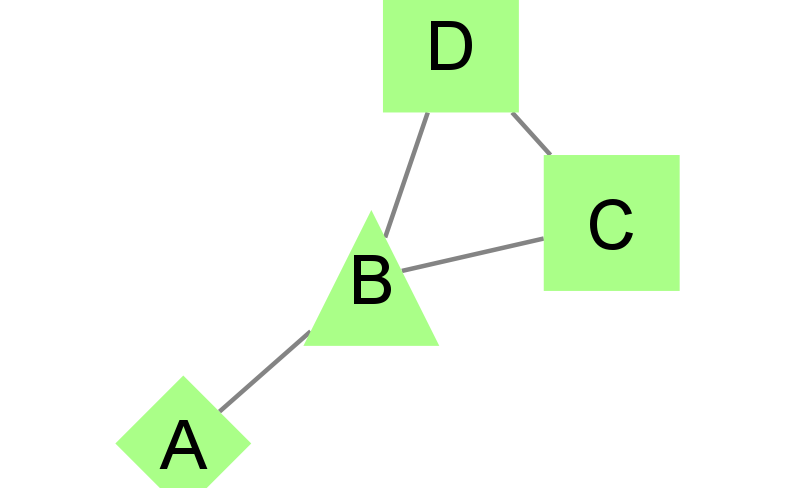

In [28]:
p4c.notebook_export_show_image()

The node shape mapping is an example of a *discrete* mapping, where a style is defined for each, discrete value. This is useful for categorical data (like type) where there is only a limited set of possible values. This is in contast to the other two other types of mappings: *continuous* and *passthrough*. In the case of expression values, for example, we will want to use *continuous* mapping (e.g., to node color) rather than an explicit color for each possible data value. py4cytoscape provides the gradient of colors in a simple way. Let’s try that one now

In [29]:
from py4cytoscape import palette_color_brewer_d_RdBu
p4c.set_node_color_mapping(**gen_node_color_map('log2fc', palette_color_brewer_d_RdBu()))

style_name not specified, so updating "default" style.


''

Note that there are `palette_color_brewer_d_RdBu` function.
This generates a divergent palette for continuous mappings of mixed-signed values.
Here `_d_` means "divergent" (does not means "discrete").

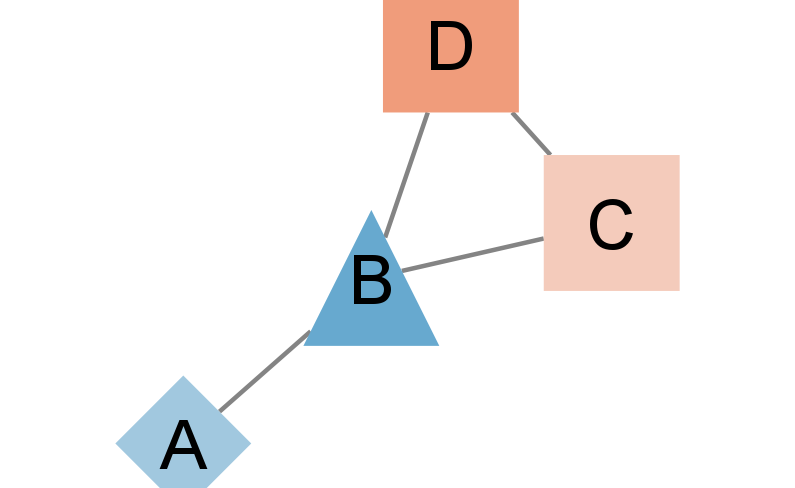

In [30]:
p4c.notebook_export_show_image()

### Selecting nodes
Let us now try selecting nodes in Cytoscape from Python. Select the C node by name:

In [31]:
p4c.select_nodes('C', 'name')

{'nodes': [106], 'edges': []}

In [32]:
p4c.get_selected_nodes()

['C']

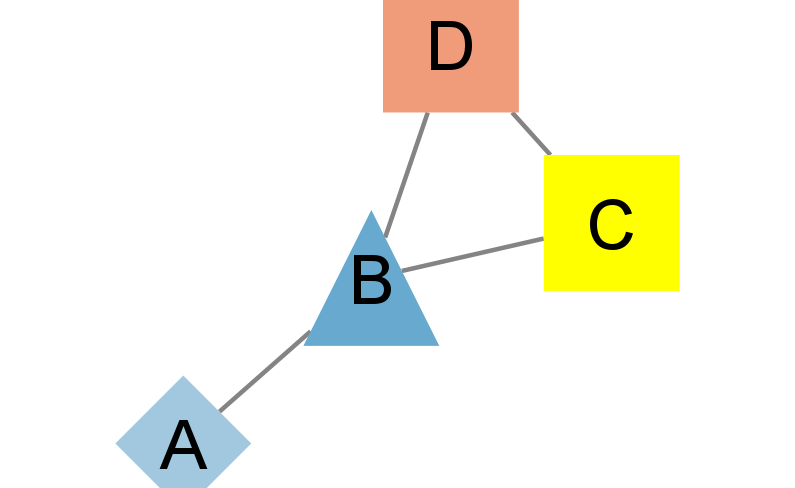

In [33]:
p4c.notebook_export_show_image()

Now we wish to extend the selected nodes to include the first neighbors of the already-selected node B. This is a common operation: for instance, after selecting one or more nodes based on experimental data or annotation, you may want to explore these in the context of interaction partners (in a protein-protein network) or in relation to upstream and downstream partners in a signaling or metabolic network. Type:

In [34]:
p4c.select_first_neighbors()

{'nodes': [105, 106, 107], 'edges': []}

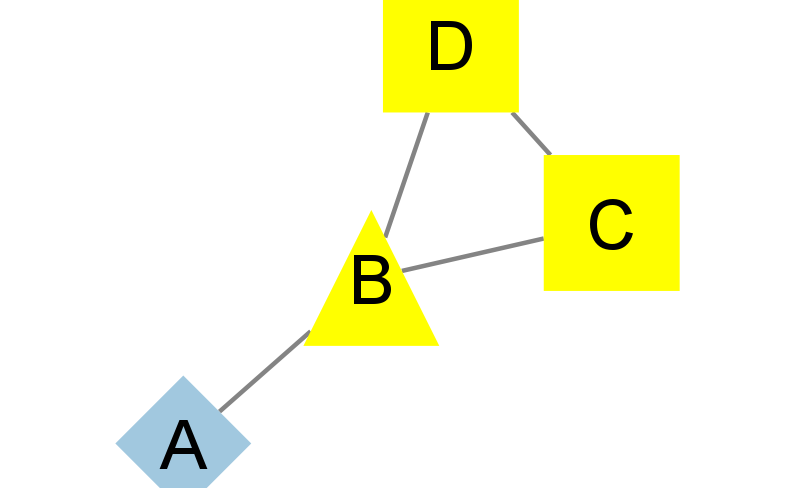

In [35]:
p4c.notebook_export_show_image()

You will see that three nodes are now selected. Get their names back to Python as a list:

In [36]:
node_names = p4c.get_selected_nodes()

In [37]:
node_names

['B', 'C', 'D']

*And*, finally, deselection works as you’d expect by means of a general *p4c.clearSelection()* function:

In [38]:
p4c.clear_selection()

''

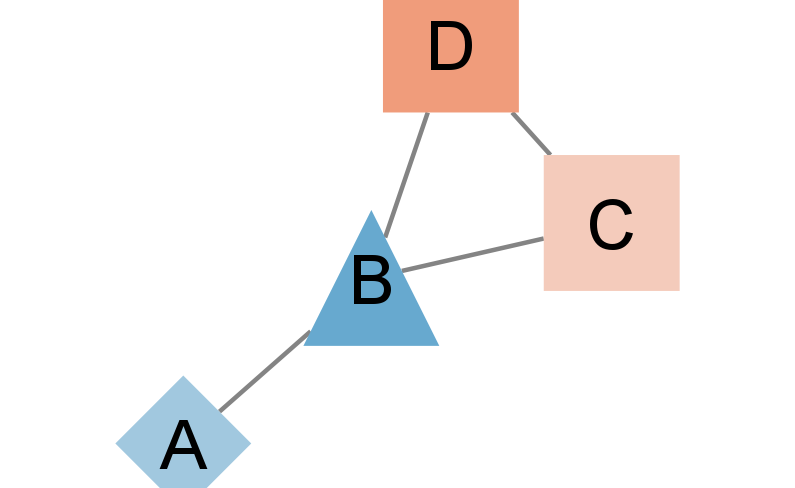

In [39]:
p4c.notebook_export_show_image()

## Browse available functions

py4cytoscape functions

In [40]:
help(p4c)

Help on package py4cytoscape:

NAME
    py4cytoscape - Interface for Py4Cytoscape.

PACKAGE CONTENTS
    _version
    apps
    collections
    commands
    cy_ndex
    cytoscape_system
    decorators
    exceptions
    filters
    groups
    layouts
    network_selection
    network_views
    networks
    notebook
    py4cytoscape_logger
    py4cytoscape_logger_settings
    py4cytoscape_notebook
    py4cytoscape_sandbox
    py4cytoscape_tuning
    py4cytoscape_utils
    sandbox
    session
    style_auto_mappings
    style_bypasses
    style_defaults
    style_dependencies
    style_mappings
    style_values
    styles
    tables
    tools
    user_interface

DATA
    CATCHUP_FILTER_SECS = 0
    CATCHUP_NETWORK_SECS = 10
    DEFAULT_BASE_URL = 'http://127.0.0.1:1234/v1'
    MODEL_PROPAGATION_SECS = 0
    PREDEFINED_SANDBOX_NAME = 'default_sandbox'

VERSION
    0.0.10

FILE
    c:\users\hoge\miniforge3\lib\site-packages\py4cytoscape\__init__.py




Category | Description | Examples
--- | --- | ---
apps | Inspecting and managing apps for Cytoscape. | *install_app<br/> disable_app<br/> get_installed_apps*
collections | Getting information about network collections. | *get_collection_list<br/> get_collection_networks*
commands | Constructing any arbitrary CyREST API or Commands API method via standard GET, PUT, POST and DELETE protocols. | *cyrest_get<br/> commands_post<br/> cyrest_api<br/> commands_run*
cy_ndex | Communicating with NDEx from within Cytoscape. | *import_network_from_ndex<br/> export_network_to_ndex<br/>*
cytoscape_system | Checking Cytoscape System information, including versions and memory usage. | *cytoscape_ping<br/> cytoscape_version_info<br/>*
filters |	Selecting nodes and edges based on filter criteria. |*create_degree_filter<br/> create_column_filter<br/>*
groups | Working with groups in Cytoscape. | *create_group<br/> collapse_group<br/>*
layouts | Performing layouts in addition to getting and setting layout properties. | *layout_network<br/> get_layout_names<br/>*
networks | Creating and managing networks and retrieving information on networks, nodes and edges. | *create_network_from…<br/> create…_from_network<br/> get_network_suid<br/> export_network<br/> get_all_nodes<br/> get_edge_count<br/> get_first_neighbors<br/>*
network_selection | Manipulating selection of nodes and edges in networks. | *select_nodes<br/> invert_node_selection<br/> select_first_neighbors<br/>*
network_views | Performing view operations in addition to getting and setting view properties. | *fit_content<br/> export_image<br/> toggle_graphics_details*
session | Managing Cytoscape sessions, including save, open and close. | *open_session<br/> save_session<br/> close_session*
style_bypasses | Setting and clearing bypass values for visual properties. | *set_node_color_bypass<br/> set_edge_line_style_bypass<br/> hide_nodes*
style_defaults | Getting and setting default values for visual properties. | *set_node_shape_default<br/> set_edge_line_width_default*
style_dependencies | Getting and setting style dependencies. | *lock_node_dimensions*
style_mappings | Defining mappings between table column values and visual properties. | *map_visual_property<br/> update_style_mapping<br/> set_node_size_mapping<br/> set_edge_color_mapping*
styles | Managing styles and retrieving general lists of properties relevant to multiple style modes. | *create_visual_style<br/> set_visual_style<br/> export_visual_styles<br/> get_arrow_shapes*
style_values | Retrieving current values for visual properties. | *get_node_width<br/> get_edge_color<br/> get_network_zoom*
tables | Managing table columns and table column functions, like map and rename, as well as loading and extracting table data in Cytoscape. | *get_table_columns<br/> rename_table_column<br/> load_table_data<br/> map_table_column*
tools | Performing actions found in the Tools Menu in Cytoscape. | *cybrowser_dialog<br/> diffusion_basic*
user_interface | Controling the panels in the Cytoscape user interface. | *hide_panel<br/> float_panel<br/> dock_panel*


## More examples

The Cytoscape team is collecting scripts from the community in a public GitHub repository at https://github.com/cytoscape/cytoscape-automation/tree/master/for-scripters/Python.

## Development

The py4cytoscape project code and documentation is maintained at GitHub: https://github.com/cytoscape/py4cytoscape. All bugs and feature requests are tracked as Issues, https://github.com/cytoscape/py4cytoscape/issues.

## Credits

- Paul Shannon’s generous advice and mentorship was very important for transforming this package from using XMLRPC and CytoscapeRPC to using CyREST.
- David Otasek, Keiichiro Ono and Barry Demchak kindly provided CyREST as well as help and support for new functionalities and changes.
- Mark Grimes and Ruth Isserlin kindly provided helpful user feedback.
- Julia Gustavsen generously developed various use cases/examples for using RCy3 with biological data during GSOC 2016, https://github.com/jooolia/gsoc_Rcy3_vignettes/blob/master/blog_post_drafts/final_work_submission.md.
- Tanja Muetze provided many years of development, design, maintenance and documentation for the RCy3 project.
- All contributors, new and old, are dynamically acknowledged in our Contributor Graph, https://github.com/cytoscape/py4cytoscape/graphs/contributors

## References

1. Shannon P, Markiel A, Ozier O, Baliga NS, Wang JT, Ramage D, Amin N, Schwikowski B, Ideker T. 2003. Cytoscape: a software environment for integrated models of biomolecular interaction networks. Genome Res. Nov;13(11):2498-504
2. Huber W, Carey VJ, Long L, Falcon S, Gentleman R. 2007. Graphs in molecular biology. BMC Bioinformatics. 2007 Sep 27;8.
3. Ono K, Muetze T, Kolishovski G, Shannon P, Demchak B. CyREST: Turbocharging Cytoscape Access for External Tools via a RESTful API [version 1; referees: 2 approved]. F1000Research 2015, 4:478.
4. Otasek D, Morris JH, Bouças J, Pico AR, Demchak B. 2019. Cytoscape Automation: empowering workflow-based network analysis. Genome Biol. 2019 Sep 2;20(1):185.
